## Image Similarity Search
#### In this Notebook, we evaluate 3 similarity search methods, Cosine Similarity, Euclidean Distance, and Jaccard Similarity on image datasets. We evaluate and compare the performance of each search methods using Confusion Matrix

In [1]:
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet
from PIL import Image



In [2]:
image_folder = "data/image_data/images"
file_path = "data/image_data/image_pairs.xlsx"
df = pd.read_excel(file_path)
df.head()

,Image 1,Image 2,Similarity
0,145721498_a27d2db576.jpg,146577646_9e64b8c2dc.jpg,1
1,166321294_4a5e68535f.jpg,166433861_70b66cd381.jpg,1
2,172097783_292c5413d8.jpg,172092464_d9eb4f4f2f.jpg,1
3,186890605_ddff5b694e.jpg,186890601_8a6b0f1769.jpg,1
4,236095031_5cb17dc54a.jpg,219843860_332e5ca7d4.jpg,1


In [3]:
# Initialize the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

def get_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224 pixels
    img_array = image.img_to_array(img)  # Convert image to numpy array
    expanded_img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    preprocessed_img = preprocess_input(expanded_img_array)  # Preprocess for ResNet
    features = model.predict(preprocessed_img)  # Extract features
    return features.flatten()  # Flatten the feature vector for similarity calculation

image1_embeddings = []
image2_embeddings = []

for index, row in df.iterrows():
    img1_path = os.path.join(image_folder, row['Image 1'])
    img2_path = os.path.join(image_folder, row['Image 2'])

    if not os.path.exists(img1_path) or not os.path.exists(img2_path):
        print(f"Skipping row {index} - file not found")
        image1_embeddings.append(np.zeros(2048))
        image2_embeddings.append(np.zeros(2048))
        continue

    emb1 = get_embedding(img1_path)
    emb2 = get_embedding(img2_path)

    image1_embeddings.append(emb1)
    image2_embeddings.append(emb2)

# Convert to numpy arrays
image1_embeddings = np.array(image1_embeddings)
image2_embeddings = np.array(image2_embeddings)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━

In [4]:
# Function to generate PDF report of misclassified image pairs
def save_false_cases(similarity_column, score_column, pdf_path, method_name):

    # Identify misclassified pairs
    false_positives = df[(df[similarity_column] == 1) & (df['Similarity'] == 0)]
    false_negatives = df[(df[similarity_column] == 0) & (df['Similarity'] == 1)]
    false_cases = pd.concat([false_positives, false_negatives])

    # Prepare PDF
    doc = SimpleDocTemplate(pdf_path, pagesize=A4)
    styles = getSampleStyleSheet()
    story = []

    story.append(Paragraph(f"<b>{method_name} Misclassified Image Pairs</b>", styles["Title"]))
    story.append(Spacer(1, 0.15 * inch))

    # Loop through false cases
    for idx, row in false_cases.iterrows():
        img1_path = os.path.join(image_folder, row['Image 1'])
        img2_path = os.path.join(image_folder, row['Image 2'])
        sim_score = row[score_column]
        true_label = row['Similarity']
        similarity_label = row[similarity_column]

        story.append(Paragraph(f"<b>Pair Index:</b> {idx}", styles["Heading3"]))
        story.append(Paragraph(
            f"<b>True Similarity:</b> {true_label} | "
            f"<b>{similarity_column}:</b> {int(similarity_label)} | "
            f"<b>{score_column}:</b> {sim_score:.4f}",
            styles["Normal"]
        ))
        story.append(Spacer(1, 0.15 * inch))

        try:
            # Combine both images side by side using matplotlib
            img1 = Image.open(img1_path)
            img2 = Image.open(img2_path)

            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(img1)
            axs[0].set_title("Image 1")
            axs[0].axis('off')
            axs[1].imshow(img2)
            axs[1].set_title("Image 2")
            axs[1].axis('off')

            buf = io.BytesIO()
            plt.tight_layout()
            plt.savefig(buf, format='png')
            plt.close(fig)
            buf.seek(0)

            story.append(RLImage(buf, width=6*inch, height=3*inch))
            story.append(Spacer(1, 0.15 * inch))
        except Exception as e:
            story.append(Paragraph(f"<font color='red'>Error loading images: {e}</font>", styles["Normal"]))
            story.append(Spacer(1, 0.15 * inch))

    # Build PDF
    doc.build(story)
    print(f"Saved PDF report to {pdf_path}")


## Cosine Similarity

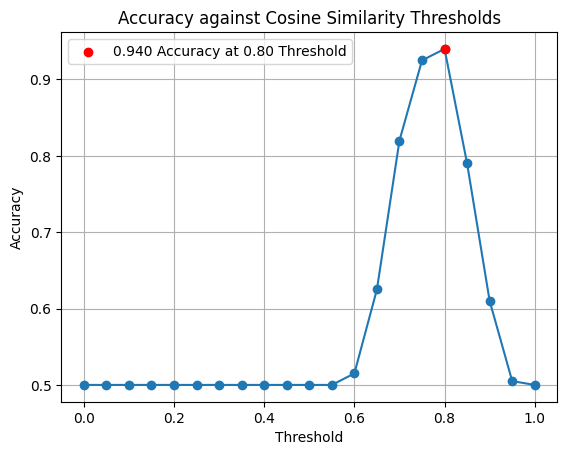

In [5]:
thresholds = []
accuracies = []

# Compute cosine similarity score for all pairs
cosine_score = cosine_similarity(image1_embeddings, image2_embeddings)
cosine_score = (cosine_score + 1) / 2 # Normalize scores to [0, 1]

for threshold in [i / 100 for i in range(0, 105, 5)]:

    # Loop through the DataFrame rows to populate the 'Cosine_Similarity' column
    for index in range(len(df)): 
        if cosine_score[index][index] > threshold: 
            df.at[index, 'Cosine_Similarity'] = 1 
        else:
            df.at[index, 'Cosine_Similarity'] = 0

    cm = confusion_matrix(df['Similarity'], df['Cosine_Similarity'])

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

max_accuracy = max(accuracies)
best_threshold = thresholds[accuracies.index(max_accuracy)]

plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy against Cosine Similarity Thresholds')
plt.grid(True)
plt.scatter(best_threshold, max_accuracy, color='red', zorder=5, label=f'{max_accuracy:.3f} Accuracy at {best_threshold:.2f} Threshold')
plt.legend()
plt.show()

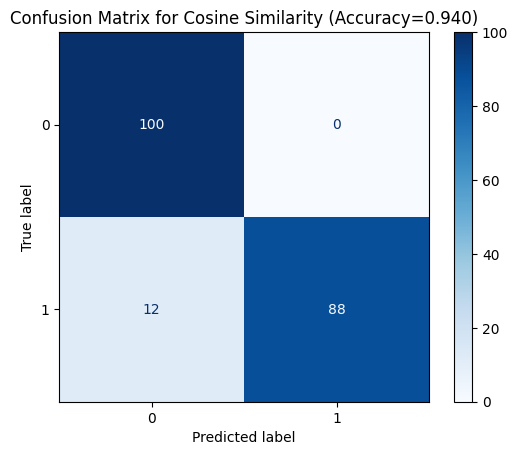

Saved PDF report to results/image_results/cosine_similarity_false_cases.pdf


In [6]:
threshold = 0.8

# Loop through the DataFrame rows to populate the 'Cosine_Similarity' and 'Cosine_Score' columns
for index in range(len(df)): 

    df.at[index, 'Cosine_Score'] = cosine_score[index][index]

    if cosine_score[index][index] > threshold: 
        df.at[index, 'Cosine_Similarity'] = 1 
    else:
        df.at[index, 'Cosine_Similarity'] = 0

cm = confusion_matrix(df['Similarity'], df['Cosine_Similarity'])

TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Cosine Similarity (Accuracy={accuracy:.3f})')
plt.show()

save_false_cases(
    similarity_column="Cosine_Similarity",
    score_column="Cosine_Score",
    pdf_path="results/image_results/cosine_similarity_false_cases.pdf",
    method_name="Cosine Similarity"
)


## Euclidean Distance

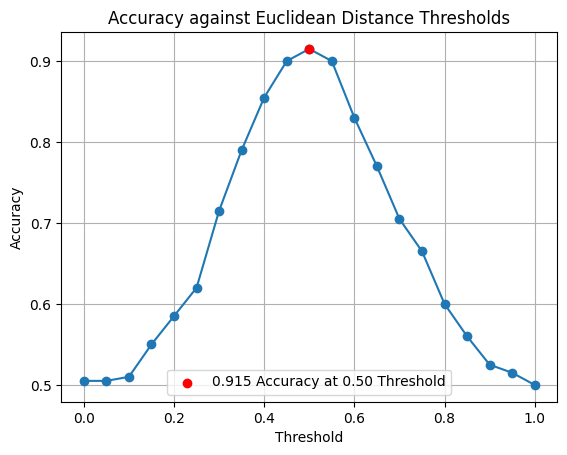

In [7]:
# List to store accuracy for each threshold
thresholds = []
accuracies = []

# Compute Euclidean distance between embeddings
euclidean_score = np.linalg.norm(image1_embeddings - image2_embeddings, axis=1)
euclidean_score = 1 - (euclidean_score - euclidean_score.min()) / (euclidean_score.max() - euclidean_score.min())# Normalize scores to range [0, 1]

for threshold in [i / 100 for i in range(0, 105, 5)]:

    # Loop through the DataFrame rows to populate the 'Euclidean_Similarity' column
    for index in range(len(df)): 
        if euclidean_score[index] > threshold:
            df.at[index, 'Euclidean_Similarity'] = 1 
        else:
            df.at[index, 'Euclidean_Similarity'] = 0

    cm = confusion_matrix(df['Similarity'], df['Euclidean_Similarity'])

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

max_accuracy = max(accuracies)
best_threshold = thresholds[accuracies.index(max_accuracy)]

plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy against Euclidean Distance Thresholds')
plt.grid(True)
plt.scatter(best_threshold, max_accuracy, color='red', zorder=5, label=f'{max_accuracy:.3f} Accuracy at {best_threshold:.2f} Threshold')
plt.legend()
plt.show()

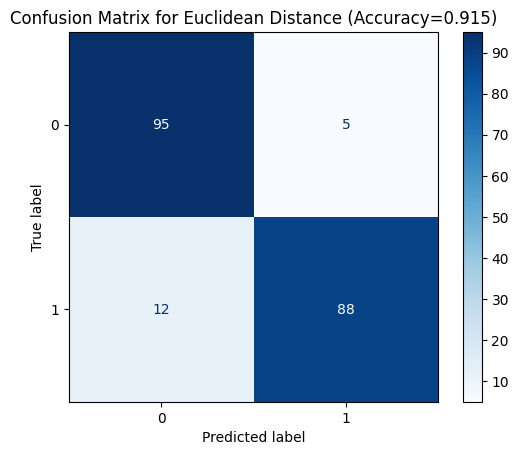

Saved PDF report to results/image_results/euclidean_distance_false_cases.pdf


In [8]:
threshold = 0.5

# Loop through the DataFrame rows to populate the 'Euclidean_Score' and 'Euclidean_Similarity' column
for index in range(len(df)): 

    df.at[index, 'Euclidean_Score'] = euclidean_score[index]

    if euclidean_score[index] > threshold: 
        df.at[index, 'Euclidean_Similarity'] = 1 
    else:
        df.at[index, 'Euclidean_Similarity'] = 0

cm = confusion_matrix(df['Similarity'], df['Euclidean_Similarity'])

TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Euclidean Distance (Accuracy={accuracy:.3f})')
plt.show()

save_false_cases(
    similarity_column="Euclidean_Similarity",
    score_column="Euclidean_Score",
    pdf_path="results/image_results/euclidean_distance_false_cases.pdf",
    method_name="Euclidean Distance"
)

## Jaccard Similarity

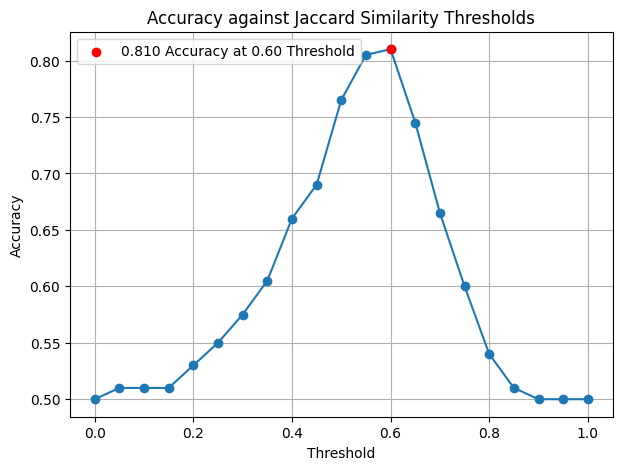

In [9]:
# Convert image into color-bin set
def image_to_histogram_set(img_path, bins_per_channel=8):
    """
    Convert an image to a set of quantized color bins.
    RGB space is divided into bins_per_channel^3 bins.
    Each non-empty bin acts as a 'visual token'.
    """
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))  # normalize image size

    # Convert to numpy array
    img_array = np.array(img)

    # Quantize each color channel
    bin_size = 256 // bins_per_channel
    quantized = (img_array // bin_size).astype(int)

    # Flatten to (num_pixels, 3)
    flat_pixels = quantized.reshape(-1, 3)

    # Convert quantized RGB to a single integer bin ID
    bin_ids = flat_pixels[:, 0] * (bins_per_channel ** 2) + \
              flat_pixels[:, 1] * bins_per_channel + \
              flat_pixels[:, 2]

    return set(bin_ids)

# Compute Jaccard similarity for each pair
similarity_scores = []

for idx, row in df.iterrows():
    img1_path = os.path.join(image_folder, row['Image 1'])
    img2_path = os.path.join(image_folder, row['Image 2'])

    if not os.path.exists(img1_path) or not os.path.exists(img2_path):
        print(f"Skipping row {idx}: missing file.")
        similarity_scores.append(0)
        continue

    set1 = image_to_histogram_set(img1_path)
    set2 = image_to_histogram_set(img2_path)

    intersection = len(set1 & set2)
    union = len(set1 | set2)
    sim = intersection / (union + 1e-10)
    similarity_scores.append(sim)

# Evaluate thresholds & accuracy
thresholds = []
accuracies = []

for threshold in [i / 100 for i in range(0, 105, 5)]:

    for index in range(len(df)):
        if similarity_scores[index] > threshold: 
            df.at[index, 'Jaccard_Similarity'] = 1 
        else:
            df.at[index, 'Jaccard_Similarity'] = 0

    cm = confusion_matrix(df['Similarity'], df['Jaccard_Similarity'])
    TP = cm[1, 1] if cm.shape == (2, 2) else 0
    TN = cm[0, 0] if cm.shape == (2, 2) else 0
    FP = cm[0, 1] if cm.shape == (2, 2) else 0
    FN = cm[1, 0] if cm.shape == (2, 2) else 0

    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-10)
    thresholds.append(threshold)
    accuracies.append(accuracy)

# Find the best threshold
max_accuracy = max(accuracies)
best_threshold = thresholds[accuracies.index(max_accuracy)]

# Plot Accuracy vs Threshold
plt.figure(figsize=(7, 5))
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy against Jaccard Similarity Thresholds')
plt.grid(True)
plt.scatter(best_threshold, max_accuracy, color='red', zorder=5, label=f'{max_accuracy:.3f} Accuracy at {best_threshold:.2f} Threshold')
plt.legend()
plt.show()


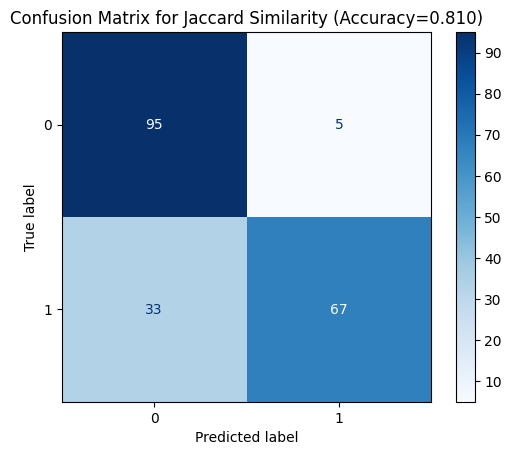

Saved PDF report to results/image_results/jaccard_similarity_false_cases.pdf


In [10]:
threshold = 0.6

# Loop through the DataFrame rows to populate the 'Jaccard_Similarity' column
for index in range(len(df)): 

    df.at[index, 'Jaccard_Score'] = similarity_scores[index]
    
    if similarity_scores[index] > threshold: 
        df.at[index, 'Jaccard_Similarity'] = 1 
    else:
        df.at[index, 'Jaccard_Similarity'] = 0

cm = confusion_matrix(df['Similarity'], df['Jaccard_Similarity'])

TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Jaccard Similarity (Accuracy={accuracy:.3f})')
plt.show()

save_false_cases(
    similarity_column="Jaccard_Similarity",
    score_column="Jaccard_Score",
    pdf_path="results/image_results/jaccard_similarity_false_cases.pdf",
    method_name="Jaccard Similarity"
)


In [11]:
# Save results to Excel file
df.to_excel("results/image_results/image_pairs_similarities.xlsx", index=False)
df.head()

,Image 1,Image 2,Similarity,Cosine_Similarity,Cosine_Score,Euclidean_Similarity,Euclidean_Score,Jaccard_Similarity,Jaccard_Score
0,145721498_a27d2db576.jpg,146577646_9e64b8c2dc.jpg,1,1.0,0.910376,1.0,0.775469,0.0,0.529851
1,166321294_4a5e68535f.jpg,166433861_70b66cd381.jpg,1,1.0,0.885707,1.0,0.778183,1.0,0.601660
2,172097783_292c5413d8.jpg,172092464_d9eb4f4f2f.jpg,1,1.0,0.884729,1.0,0.789000,1.0,0.712042
3,186890605_ddff5b694e.jpg,186890601_8a6b0f1769.jpg,1,1.0,0.914533,1.0,0.830394,1.0,0.808511
4,236095031_5cb17dc54a.jpg,219843860_332e5ca7d4.jpg,1,1.0,0.847753,1.0,0.599891,1.0,0.605769
